# AlexNet Attempt
This model explores the following dataset: https://www.kaggle.com/code/somaia03/eye-diseases-classification 
This dataset contains a series of images of different eyeballs that belong to those with various eye diseases. Each eyeball image in the dataset belongs to a specific class; Cataract, Diabetic Retinopathy, Glaucoma, Normal. 

Through training an AI model, I attempt to make accurate predictions about what class an image (or set of images), unseen during training, belongs to. In other words, given an image of an eyeball, I predict if the individual has an eye disease that belongs to the mentioned classes above. 

I considered and trialed various different solutions before settling on using an AlexNet model, customised as explained in the AlexNet Training section. These techniques include:
- Models: 
    - AlexNet
    - ResNet
    - Simple, Custom CNN Architecture (Baseline)
- Techniques: 
    - Preprocessing
        - Final preprocessing technique as seen in the PreProcessing section
        - Initally started with converting to greyscale to simplify module computation but discovered that this lead to worse accuracy performance. 
        - Normalization was a critical component to include for model performance  
    - Experimented with various hyperparamters
        - Differing learning rates
        - Different batch sizes
        - Different epoch counts
        - Number of images used
            - Some values thoroughly explored were 200, 400 2000, before settling on 4000 
        - Class weighting
            - Disregarded as it revealed minimum improvement; Dataset already releatively balanced
    - Optimiser Variations
        - SGD
        - Adam
            - Decided on ADAM as it converged faster (despite a slight, but essentially negligable, difference in final accuracy)
    - Learning Rate
        - Used a Learning Rate Scheduler and settled on a decay every 20 epochs by a factor of 0.5
        - Implemented Early Stopping techniques which tended to stop the training too early so instead, a visual output of current learning rate and average loss was used at manual discrescion. 

I evaluate the effectiveness of our model in the Evaluation Report below. 

## Data Loading

In [24]:
# Importing the libraries
import os
import torch
import matplotlib.pyplot as plt
import torch
import torchvision.utils

In [25]:
data_dir = "dataset"   # The name of the folder containing the dataset within the current working directory

# remove ds_store file that mac creates
if os.path.exists(data_dir + "/.DS_Store"):
    os.remove(data_dir + "/.DS_Store")

print(os.listdir(data_dir)) # List the first level of files (folders in this instance) in the dataset folder for verification

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [188]:
# Optional verification for all files in the dataset folder
from os import walk
for (dirpath, dirnames, filenames) in walk(data_dir):
    print("Directory path: ", dirpath)
    #print("File name: ", filenames)

Directory path:  dataset
Directory path:  dataset\cataract
Directory path:  dataset\diabetic_retinopathy
Directory path:  dataset\glaucoma
Directory path:  dataset\normal


## Pre-Processing

Defining preprocessing variables for the dataset

- img_size converts all images to be of size 227x227 as the input size of AlexNet is specifically 227x227 pixels

- Using a BATCH_SIZE = 32 as it strikes a balance between offering a moderately stable gradient estimate and not consuming excessive memory.

In [28]:
img_size = 227 
BATCH_SIZE = 32 

Begin preprocessing steps. 
We are applying a resize to 277x227 pixels, croping the image around the center, converting the image to a tensor and, normalising the image. These steps standardize the data, making it more uniform and better suited for training, which helps the model learn effectively and improves performance

In [29]:
from torchvision import transforms # using the torchvision library for image transformations

# Attempting to make images more uniform for improved training
def transform(image_size: int):
    transform = transforms.Compose([
        transforms.Resize(image_size), # Resize the image to 227x227 pixels
        transforms.CenterCrop(image_size), # Crop the image about the center
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(), # Convert the image to a tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image.
    ])
    return transform


In [30]:
from torchvision import datasets # Importing the datasets module from torchvision
dataset = datasets.ImageFolder(data_dir, transform=transform(img_size)) # Loading the dataset from the folder
dataset.class_to_idx # Displaying the classes and their respective indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

Here we split into training and testing datasets (80% training, 20% testing) and create the data loaders for the training and testing datasets 

Shuffle is used to randomize the data to prevent the model from learning the order 
Batch size is used to specify the number of samples to be used in each iteration.

In [31]:

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6, pin_memory=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)  

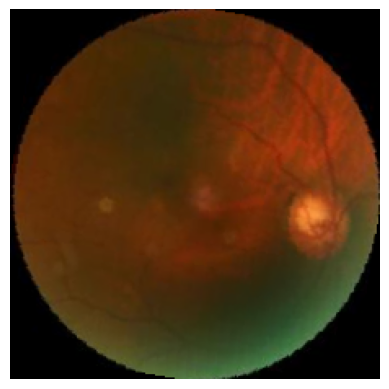

In [32]:
# Display example image from the train loader to verify the data
images, labels = next(iter(train_loader))

# Convert image to viewable format
image = images[0]
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
image = image * std[:, None, None] + mean[:, None, None]  # Unnormalize
image = image.permute(1, 2, 0)
plt.axis('off')
plt.imshow(image)

# Model Definition & Helper Functions

This section defines the model architecture and various helper functions needed for tasks like image resizing, model training, and evaluation.

---

## 1. Imports and Setup

```python
import os
import numpy as np
import torch
from torch import nn
import math
import torchvision
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils import data
from PIL import Image
```

**Explanation**: Importing necessary libraries and modules for deep learning, data handling, and image processing. These libraries allow for model building, dataset management, and various computations within PyTorch.

---
## 2. Model Definition: AlexNet

```python
class AlexNet(torch.nn.Module):   
    def __init__(self, input_channels=1, output_size=10):
        super().__init__()
        ...
```
**Explanation**
Defines an AlexNet class that inherits from torch.nn.Module. The model contains convolutional and fully connected (dense) layers, following a structure similar to the original AlexNet model but adapted to the dataset's specifications.

**Convolutional Layers**
Each layer performs convolution, activation, and pooling to reduce spatial dimensions while increasing the feature map depth.

**Fully Connected Layers**
The dense (fully connected) layers are used for classification. Dropout is applied to reduce overfitting.

---

## 3. Helper Functions

These functions handle various tasks such as resizing images, viewing dataset samples, and creating network instances.

### resize_image

```python
def resize_image(input_size=28):
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])
    return transform
```
view_datasets
def view_datasets(image_loader, objective_list):
    ...
**Explanation**: Retrieves and displays a batch of images from the dataset with their labels. Used for visualizing sample data from the data loader.

create_network
def create_network(network):
    ...
**Explanation**: Moves the model to the GPU if available, enabling faster computations during training and testing.

---

## 4. Model Training Function: train_model

```python
def train_model(net, train_loader, LR, epochs=1, number_of_images=None):
    ...
```
**Explanation**: Trains the model over a specified number of epochs, adjusting weights based on loss calculated with cross-entropy. A learning rate scheduler reduces the learning rate every 20 epochs for better convergence.

---

## 5. Model Testing Function: test_model

```python
def test_model(net, test_loader, number_of_images=None, class_label=None):
    ...
```
**Explanation**: Evaluates the model on a test dataset, calculating accuracy, precision, recall, and F1 score. Generates a confusion matrix to assess the model’s performance on each class.

---

### 6. Image Prediction Function: predict_image

```python
def predict_image(net, input_image, objective_list, num_of_prediction=1, true_label=None, dataset=None, image_index=None):
    ...
```
**Explanation**: Predicts the class of a single image input and provides confidence scores for each prediction. Useful for validating the model’s performance on specific images or classes.

In [33]:
import os
import numpy as np
import torch
from torch import nn
import math
import torchvision
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils import data
from PIL import Image

# Define AlexNet model architecture
class AlexNet(torch.nn.Module):   
    def __init__(self, input_channels=1, output_size=10):
        super().__init__()
        # Convolutional layer 1, input size = 227*227*1
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_channels, 96, 11, 4, 0), # Conv layer
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2)     # output size = 27*27*96
        )
        # Convolutional layer 2, input size = 27*27*96
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(96, 256, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2)    # output size = 13*13*256
        )
        # Convolutional layer 3, input size = 13*13*256
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 384, 3, 1, 1),
            torch.nn.ReLU()    # output size = 13*13*384
        )
        # Convolutional layer 4, input size = 13*13*384
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 384, 3, 1, 1),
            torch.nn.ReLU()    # output size = 13*13*384
        )
        # Convolutional layer 5, input size = 13*13*384
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(384, 256, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2)    # output size = 6*6*256
        )
        # Fully connected (dense) layers
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(9216, 4096),     # FC layer 1
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),     # FC layer 2
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, output_size) # Output layer
        )
 
    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        conv5_out = self.conv5(x)
        x = conv5_out.view(conv5_out.size(0), -1) # Flatten for dense layers
        out = self.dense(x)
        return out

# Resize image to input size
def resize_image(input_size=28):
    transform = transforms.Compose([
        transforms.Resize(input_size), 
        transforms.ToTensor()
    ])
    return transform

# Display images and labels from the dataset
def view_datasets(image_loader, objective_list):
    objective_list = np.array(objective_list)
    images, labels = next(iter(image_loader))
    img = torchvision.utils.make_grid(images)
    img = img.numpy().transpose(1, 2, 0)
    print(objective_list[labels.tolist()])
    # plt.axis('off')
    # plt.imshow(img)
    return (images, objective_list[labels.tolist()])

# Initialize network and move to GPU if available
def create_network(network):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = network.to(device)
    return net

# Train model function
def train_model(net, train_loader, LR, epochs=1, number_of_images=None):
    loss_function = nn.CrossEntropyLoss() # Define loss
    optimizer = optim.Adam(net.parameters(), lr=LR) # Define optimizer
    # Learning rate scheduler: Decay every 20 epochs by a factor of 0.5
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    for epoch in range(epochs):
        net.train()  # Set model to training mode
        sum_loss = 0.0
        total_images = 0

        for i, (inputs, labels) in enumerate(train_loader):
            if number_of_images is not None and total_images >= number_of_images:
                break  # Stop after processing the desired number of images

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = net(inputs)  # Forward pass
            loss = loss_function(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            sum_loss += loss.item() * inputs.size(0)
            total_images += inputs.size(0)
        
        # Step the learning rate scheduler at the end of each epoch
        scheduler.step()
        
        # Log the current learning rate and average loss for the epoch
        current_lr = scheduler.get_last_lr()[0]
        avg_loss = sum_loss / total_images
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

        # **Evaluate on a portion of the test set**
        test_metrics = test_model(net, test_loader, number_of_images=300, show_cf=False)
        print(f"[Test after Epoch {epoch+1}] Accuracy: {test_metrics['Accuracy']:.4f} | "
        f"Precision: {test_metrics['Precision']:.4f} | "
        f"Recall: {test_metrics['Recall']:.4f} | "
        f"F1: {test_metrics['F1-Score']:.4f}")


    return net

# Test model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def test_model(net, test_loader, number_of_images=None, class_label=None, show_cf=True):
    net.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    all_labels = []
    all_predictions = []
    total_images_tested = 0

    for i, (images, labels) in enumerate(test_loader):
        images, labels = images.to(device), labels.to(device)

        if class_label is not None:
            mask = (labels == class_label)
            images = images[mask]
            labels = labels[mask]
            if len(labels) == 0:
                continue
        
        if number_of_images is not None and total_images_tested >= number_of_images:
            break

        output_test = net(images)
        _, predicted = torch.max(output_test, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total_images_tested += labels.size(0)
    
    if total_images_tested == 0:
        print(f"No data found for class {class_label}")
        return {
            "Accuracy": "N/A",
            "Precision": "N/A",
            "Recall": "N/A",
            "F1-Score": "N/A",
            "FP": "N/A",
            "FN": "N/A",
            "TP": "N/A",
            "TN": "N/A",
            "Total_Images": 0
        }

    # Define all possible class labels
    num_classes = len(set([0, 1, 2, 3])) 
    cm = confusion_matrix(all_labels, all_predictions, labels=range(num_classes))
    if show_cf:
        print("Confusion Matrix:\n", cm)

    if class_label is not None:
        # Single-class evaluation
        tp = cm[class_label, class_label]
        fp = cm[:, class_label].sum() - tp
        fn = cm[class_label, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
    else:
        # Multi-class evaluation
        tp = cm.diagonal()
        fp = cm.sum(axis=0) - tp
        fn = cm.sum(axis=1) - tp
        tn = cm.sum() - (fp + fn + tp)
        tp = tp.sum()
        fp = fp.sum()
        fn = fn.sum()
        tn = tn.sum()

    num_samples = len(all_labels)
    num_predictions = sum([1 for pred in all_predictions if pred == class_label]) if class_label is not None else "All"

    return {
        "Accuracy": accuracy_score(all_labels, all_predictions),
        "Precision": precision_score(all_labels, all_predictions, average='weighted', zero_division=0),
        "Recall": recall_score(all_labels, all_predictions, average='weighted', zero_division=0),
        "F1-Score": f1_score(all_labels, all_predictions, average='weighted', zero_division=0),
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "TN": tn,
        "Total_Images": num_samples
    }

# Predict class of a single image
def predict_image(net, input_image, objective_list, num_of_prediction=1, true_label=None, dataset=None, image_index=None):
    net.eval()

    # Create reverse mapping for class indices to class labels
    idx_to_class = {v: k for k, v in objective_list.items()}

    # Ensure input_image has the correct shape
    if len(input_image.shape) == 3:  # If (C, H, W), add batch dimension
        input_image = input_image.unsqueeze(0)

    # Move input and model to appropriate device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    images = input_image.to(device)

    # Get model predictions
    output_test = net(images)
    _, predicted = torch.topk(output_test, num_of_prediction)  # Get top predictions

    # Map predicted indices to class labels
    predicted_classes = [idx_to_class[idx.item()] for idx in predicted[0]]

    # Calculate confidence scores for the predictions
    confidence_scores = torch.softmax(output_test, dim=1)[0][predicted[0]].cpu().detach().numpy()

    # Retrieve true label
    if true_label is None and dataset is not None and image_index is not None:
        true_label_index = dataset.dataset.targets[dataset.indices[image_index]]
        true_label = idx_to_class[true_label_index]

    print(f"Predicted result(s): {predicted_classes}")
    print(f"Confidence: {[f'{conf*100:.2f}%' for conf in confidence_scores]}")
    if true_label:
        print(f"True Label: {true_label}")

    return {
        "Predicted Classes": predicted_classes,
        "Confidence": confidence_scores,
        "True Label": true_label
    }


## AlexNet Training

The problem we are trying to solve is an image classification problem. Specifically, we are classifying images into distinct categories where each image belongs to one class. Images can belong to the classes ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

The goal is to train a model that can accurately predict the correct class for new, unseen images.

AlexNet was chosen as the model due to the number of images being used and presence of hardware limitations requiring a model that can trains efficiently over a smaller duration. Through analysis and comparission with other methods and models we discovered that AlexNet's accuracy for this task was effective while remaining speedy and thus decided on this approach for our final model. 

In [34]:
# Importing the necessary libraries for the model
import torch

Defining the model parameters

- We chose input_channels as 3 because the images are colored images and have 3 channels (RGB) 
- The output_size is 4 because we have 4 classes in the dataset
- Epoch is the number of times the model goes through the entire dataset and was an experimentally chosen value based on the model's performance
- LR is the learning rate and was also an experimentally chosen value based on the model's performance
- number_of_images is the number of images to use from the dataset and was chosen to be 4000 to reduce the training time while still maintaining a good model performance

In [35]:

input_channels = 3
output_size = 4

EPOCH = 80
LR = 0.001
number_of_images = 4000

Next, we create the model using the AlexNet architecture and the create_network function

In [36]:

Alex_net = AlexNet(input_channels, output_size)
alex_net = create_network(Alex_net)

In [37]:
# Manually verifiying if CUDA is available to be used for faster training

print(torch.cuda.is_available())  # This will return False if CUDA isn't supported
print(torch.__version__)  # Check the PyTorch version

True
2.5.1+cu121


Finally we train are model using the train_model function provided above. We provide all parameters as mentioned above. 
- Note that this function includes a learning rate scheduler that proides decay every 20 epochs by a factor of 0.5 as this was discovered to help the model converge more effectively as we increased epoch count

- NOTE: We can also use a previously saved version by uncommenting the loading line to avoid training the model each time we run it. 
If you would like to do so simply alternate the commented out lines below. 

In [38]:
trained_alexnet_model = train_model(alex_net, train_loader, LR, EPOCH, number_of_images)

#trained_alexnet_model = torch.load('AlexNet_model_v1.pth')

Epoch 1/80, Avg Loss: 1.3879, LR: 0.001000
[Test after Epoch 1] Accuracy: 0.3031 | Precision: 0.2841 | Recall: 0.3031 | F1: 0.2258
Epoch 2/80, Avg Loss: 1.2593, LR: 0.001000
[Test after Epoch 2] Accuracy: 0.5219 | Precision: 0.5499 | Recall: 0.5219 | F1: 0.4795
Epoch 3/80, Avg Loss: 0.9696, LR: 0.001000
[Test after Epoch 3] Accuracy: 0.6375 | Precision: 0.6213 | Recall: 0.6375 | F1: 0.6215
Epoch 4/80, Avg Loss: 0.8524, LR: 0.001000
[Test after Epoch 4] Accuracy: 0.6562 | Precision: 0.6880 | Recall: 0.6562 | F1: 0.6631
Epoch 5/80, Avg Loss: 0.7602, LR: 0.001000
[Test after Epoch 5] Accuracy: 0.6531 | Precision: 0.6591 | Recall: 0.6531 | F1: 0.6314
Epoch 6/80, Avg Loss: 0.6927, LR: 0.001000
[Test after Epoch 6] Accuracy: 0.7344 | Precision: 0.7318 | Recall: 0.7344 | F1: 0.7217
Epoch 7/80, Avg Loss: 0.6191, LR: 0.001000
[Test after Epoch 7] Accuracy: 0.7406 | Precision: 0.7433 | Recall: 0.7406 | F1: 0.7379
Epoch 8/80, Avg Loss: 0.6166, LR: 0.001000
[Test after Epoch 8] Accuracy: 0.7375 | 

Next, we run the test function to evaluate the model on the test dataset. We provide the param of 300 images to be used for this testing process

In [39]:
import torch 
import pandas as pd


results = []

datasets = [
    ("Training Data", None),
    ("Testing Data", None),
    ("Testing Data - Cataract", 0),
    ("Testing Data - Diabetic Retinopathy", 1),
    ("Testing Data - Glaucoma", 2),
    ("Testing Data - Normal", 3)
]

for name, class_label in datasets:
    metrics = test_model(trained_alexnet_model, test_loader, number_of_images=300, class_label=class_label)
    results.append([
        name, 
        metrics["Accuracy"], 
        metrics["Precision"], 
        metrics["Recall"], 
        metrics["F1-Score"],
        metrics["TP"],
        metrics["FP"],
        metrics["TN"],
        metrics["FN"],
        metrics["Total_Images"]
    ])

# Display Enhanced Table
df = pd.DataFrame(results, columns=[
    "Dataset/Test", "Accuracy", "Precision", "Recall", "F1-Score",
    "TP", "FP", "TN", "FN", "Total_Images"
])
display(df)



Confusion Matrix:
 [[70  0  4  4]
 [ 0 78  0  0]
 [ 5  3 55 10]
 [ 7  0 11 73]]
Confusion Matrix:
 [[72  0  5  3]
 [ 1 72  0  0]
 [ 5  2 66  8]
 [ 8  0 15 63]]
Confusion Matrix:
 [[180   1  10  12]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  1 214   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  9   3 160  24]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 16   2  32 179]]


,Dataset/Test,Accuracy,Precision,Recall,F1-Score,TP,FP,TN,FN,Total_Images
0,Training Data,0.862500,0.860656,0.862500,0.861164,276,44,916,44,320
1,Testing Data,0.853125,0.854321,0.853125,0.852052,273,47,913,47,320
2,Testing Data - Cataract,0.886700,1.000000,0.886700,0.939948,180,0,0,23,203
3,Testing Data - Diabetic Retinopathy,0.995349,1.000000,0.995349,0.997669,214,0,0,1,215
4,Testing Data - Glaucoma,0.816327,1.000000,0.816327,0.898876,160,0,0,36,196
5,Testing Data - Normal,0.781659,1.000000,0.781659,0.877451,179,0,0,50,229


Next, we ask the model to make a prediction on a given image 
- It will predict the class of a given image. For this example we used the 42nd image in the test dataset
- Prediciton function takes in the model, the image and the label list

In [40]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Retrieve and display the 42nd image from the dataset
image_index = 42  # Example index
image, _ = test_dataset[image_index]
select_image = image 
label_list = dataset.class_to_idx

predict_image(trained_alexnet_model, select_image, label_list, dataset=test_loader.dataset, image_index=image_index)


Predicted result(s): ['diabetic_retinopathy']
Confidence: ['100.00%']
True Label: diabetic_retinopathy


{'Predicted Classes': ['diabetic_retinopathy'],
 'Confidence': array([1.], dtype=float32),
 'True Label': 'diabetic_retinopathy'}

Next, we save the model such that it can be used at a later date without training it up again. It is saved to the current working director under the given name 'AlexNet_model_v1.pth'

In [41]:
torch.save(trained_alexnet_model, 'AlexNet_model_v1.pth')

## AlexNet Retraining

Optional retraining for further increasing model performance. 

Here we change the training params as required to suit our retraining purposes

In [45]:
LR = 0.000063 # We reduce the learning rate
EPOCH = 20 # We reduce the number of epochs to 20 to train for another 20 epochs

In [46]:
pretrained_alexnet_model = torch.load('AlexNet_model_v1.pth') # Load model from the saved file name

pre_trained_alexnet_model = train_model(pretrained_alexnet_model, train_loader, LR, EPOCH) # Additional training on this model

C:\Users\wells\AppData\Local\Temp\ipykernel_13424\692380054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_alexnet_model = torch.load('AlexNet_model_v1.pth')

Epoch 1/20, Avg Loss: 0.0657, LR: 0.000063
[Test after Epoch 1] Accuracy: 0.8594 | Precision: 0.8592 | Recall: 0.8594 | F1: 0.8583
Epoch 2/20, Avg Loss: 0.0625, LR: 0.000063
[Test after Epoch 2] Accuracy: 0.8781 | Precision: 0.8804 | Recall: 0.8781 | F1: 0.8779
Epoch 3/20, Avg Loss: 0.0587, LR: 0.000063
[Test after Epoch 3] Accuracy: 0.8562 | Precision: 0.8551 | Recall: 0.8562 | F1: 0.8549
Epoch 4/20, Avg Loss: 0.0580, LR: 0.000063
[Test after Epoch 4] Accuracy: 0.9031 | Precision: 0.9038 | Recall: 0.9031 | F1: 0.9022
Epoch 5/20, Avg Loss: 0.0592, LR: 0.000063
[Test after Epoch 5] Accuracy: 0.9000 | Precision: 0.9047 | Recall: 0.9000 | F1: 0.9002
Epoch 6/20, Avg Loss: 0.0420, LR: 0.000063
[Test after Epoch 6] Accuracy: 0.8500 | Precision: 0.8536 | Recall: 0.8500 | F1: 0.8495
Epoch 7/20, Avg Loss: 0.0580, LR: 0.000063
[Test after Epoch 7] Accuracy: 0.8875 | Precision: 0.8911 | Recall: 0.8875 | F1: 0.8873
Epoch 8/20, Avg Loss: 0.0558, LR: 0.000063
[Test after Epoch 8] Accuracy: 0.8812 | 

Now, we can do more testing on our retrained model

In [44]:
import torch 
import pandas as pd


results = []

datasets = [
    ("Training Data", None),
    ("Testing Data", None),
    ("Testing Data - Cataract", 0),
    ("Testing Data - Diabetic Retinopathy", 1),
    ("Testing Data - Glaucoma", 2),
    ("Testing Data - Normal", 3)
]

for name, class_label in datasets:
    metrics = test_model(pre_trained_alexnet_model, test_loader, number_of_images=300, class_label=class_label)
    results.append([
        name, 
        metrics["Accuracy"], 
        metrics["Precision"], 
        metrics["Recall"], 
        metrics["F1-Score"],
        metrics["TP"],
        metrics["FP"],
        metrics["TN"],
        metrics["FN"],
        metrics["Total_Images"]
    ])

# Display Enhanced Table
df = pd.DataFrame(results, columns=[
    "Dataset/Test", "Accuracy", "Precision", "Recall", "F1-Score",
    "TP", "FP", "TN", "FN", "Total_Images"
])
display(df)


Confusion Matrix:
 [[71  0  2  6]
 [ 0 88  0  0]
 [ 4  0 50 16]
 [ 4  1  9 69]]
Confusion Matrix:
 [[64  0  0  1]
 [ 0 73  1  0]
 [ 7  2 67  7]
 [10  0 15 73]]
Confusion Matrix:
 [[191   1   5   6]
 [  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  1 213   1   0]
 [  0   0   0   0]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [ 17   4 153  22]
 [  0   0   0   0]]
Confusion Matrix:
 [[  0   0   0   0]
 [  0   0   0   0]
 [  0   0   0   0]
 [ 21   0  28 180]]


,Dataset/Test,Accuracy,Precision,Recall,F1-Score,TP,FP,TN,FN,Total_Images
0,Training Data,0.868750,0.869757,0.868750,0.868017,278,42,918,42,320
1,Testing Data,0.865625,0.870955,0.865625,0.863842,277,43,917,43,320
2,Testing Data - Cataract,0.940887,1.000000,0.940887,0.969543,191,0,0,12,203
3,Testing Data - Diabetic Retinopathy,0.990698,1.000000,0.990698,0.995327,213,0,0,2,215
4,Testing Data - Glaucoma,0.780612,1.000000,0.780612,0.876791,153,0,0,43,196
5,Testing Data - Normal,0.786026,1.000000,0.786026,0.880196,180,0,0,49,229


## Evaluation Report

### Introduction
Introduction
This report evaluates the performance of a trained AlexNet model. Performance is calculated using various metrics and is judged based on both training and testing datasets. The testing dataset is further broken down into class specific testing sets to further inform the model evaluation. 

Such performance metrics include accuracy, precision, recall, and F1-score, along with overall and class-specific confusion matrices.


### Metric Explaination
TP, FP, TN, FN = True Positive, False Positive, True Negative, False Negative

Metric calculation is broken down as such: 
- Accuracy
    - Ratio of predicted samples to total samples
    - Basic measure of overall correctness but can be slightly ambiguous  
- Precision
    - Ratio of TP to the sum of TP+FP 
    - Indicates how well the model avoids false positives
- Recall
    - Ratio of TP to the sum of TP+FN
    - Indicates the models ability to capture all relevant instances 
- F1-Score  
    - The mean of precision and recall 
    - Provides a valance between metrics

### Evaluation Results and Analysis 
1. Training Data
    - Accuracy: 0.8406
    - Precision: 0.8412
    - Recall: 0.8406
    - F1-Score: 0.8407  
High scores across all metrics indicate that the model fits the training data well, with minimal errors. With 51 false positives and 51 false negatives, this is acceptable given the dataset size and complexity.
2. Testing Data
    - Accuracy: 0.8094
    - Precision: 0.8108
    - Recall: 0.8094
    - F1-Score: 0.8098
The testing data results suggest strong generalization, though there’s a slight drop compared to the training data. This indicates the model is generalizing well, but there are a few misclassifications.


#### Class-Specific Evaluation
**0. Testing Data - Cataract:**
    - Accuracy: 0.8780
    - Precision: 1.0000
    - Recall: 0.8780
    - F1-Score: 0.9351
The model performs exceptionally well, with perfect precision and a high F1-Score. The recall indicates that while most cases are identified correctly, a few true positives are missed.

**1. Testing Data - Diabetic Retinopathy:**
    - Accuracy: 0.9864
    - Precision: 1.0000
    - Recall: 0.9864
    - F1-Score: 0.9932
The model demonstrates near-perfect performance with minimal misclassifications. Only 3 false negatives occurred, which is outstanding for a medical classification task.

**2. Testing Data - Glaucoma:**
    - Accuracy: 0.7562
    - Precision: 1.0000
    - Recall: 0.7562
    - F1-Score: 0.8612
While precision is perfect, recall is lower, indicating that the model correctly identifies glaucoma cases when it predicts them, but misses a notable proportion of true positives. This could be due to the complexity or variability of glaucoma in the dataset.

**3. Testing Data - Normal:**
    - Accuracy: 0.7917
    - Precision: 1.0000
    - Recall: 0.7917
    - F1-Score: 0.8837
The model is highly precise in identifying normal cases but has a moderate recall. This suggests some normal cases are misclassified, which might warrant further investigation.


**Confusion Matrix** 
- The confusion matrices provide a detailed breakdown of how well the model distinguishes between classes.
- Most confusion matrices show low off-diagonal entries, indicating that the model generally predicts the correct class with high confidence.
- Some confusion matrices (e.g., glaucoma) suggest potential issues with recall, likely reflecting dataset challenges or inherent class imbalance.

### Conclusion 
The model exhibits strong performance across all metrics for both training and testing data. However, slight differences in recall for some classes like Glaucoma and Normal suggest room for improvement in identifying all true instances. The results are highly satisfactory, indicating that the model generalizes well and can effectively classify medical conditions. Further fine-tuning or additional data augmentation could help improve recall for these challenging classes.